# Quantum Teleportation Circuit

## Introduction
Quantum teleportation is a protocol that allows the state of a qubit to be transmitted from one location to another using two bits of classical communication and a shared Bell pair. It is a fundamental concept in quantum information theory.

In this notebook, we will implement the quantum teleportation protocol using Qiskit. We will demonstrate how Alice can send a quantum state $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$ to Bob, even though they are physically separated.

## Protocol Overview
1. **Initialization**: Alice has a qubit $q_0$ in state $|\psi\rangle$. Alice and Bob share a Bell pair ($q_1, q_2$), where Alice holds $q_1$ and Bob holds $q_2$.
2. **Bell Measurement**: Alice performs a Bell measurement on her qubits $q_0$ and $q_1$. This collapses the state and gives her two classical bits.
3. **Classical Communication**: Alice sends the two classical bits to Bob.
4. **Correction**: Bob applies quantum gates ($X$ and/or $Z$) to his qubit $q_2$ based on the classical bits he received to recover the state $|\psi\rangle$.

## No-Cloning Theorem
The No-Cloning Theorem states that it is impossible to create an identical copy of an arbitrary unknown quantum state. In teleportation, the original state $|\psi\rangle$ on Alice's qubit is destroyed (collapsed) during the process, so no cloning occurs. The state is moved, not copied.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt

# Use the AerSimulator
simulator = AerSimulator()

## Step 1: Initialization

We start by creating a quantum circuit with 3 qubits and 3 classical bits.
- **$q_0$**: The qubit to be teleported (Alice's payload).
- **$q_1$**: Alice's half of the entangled pair.
- **$q_2$**: Bob's half of the entangled pair.

We will initialize $q_0$ to a specific state $|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$.

In [2]:
# Create Quantum and Classical Registers
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz") # For measuring q0
crx = ClassicalRegister(1, name="crx") # For measuring q1
teleportation_circuit = QuantumCircuit(qr, crz, crx)

# Initialize Alice's state (psi) on q0
# Let's create a random state for demonstration, or we can define specific alpha/beta
psi = random_statevector(2)
print("Initial State |psi>:")
display(array_to_latex(psi))

# Initialize q0 to this state
teleportation_circuit.initialize(psi, 0)
teleportation_circuit.barrier()

Initial State |psi>:


<IPython.core.display.Latex object>

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

## Step 2: Create Bell Pair (Entanglement)

Alice and Bob share an entangled Bell pair. We create this by applying a Hadamard gate to $q_1$ and then a CNOT gate with $q_1$ as control and $q_2$ as target. This puts $q_1$ and $q_2$ in the state $\frac{|00\rangle + |11\rangle}{\sqrt{2}}$.

In [3]:
teleportation_circuit.h(1)
teleportation_circuit.cx(1, 2)
teleportation_circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

## Step 3: Alice's Operations (Bell Measurement)

Alice performs a CNOT gate with $q_0$ as control and $q_1$ as target, followed by a Hadamard gate on $q_0$. Then she measures both $q_0$ and $q_1$.

In [4]:
teleportation_circuit.cx(0, 1)
teleportation_circuit.h(0)
teleportation_circuit.barrier()

# Measure Alice's qubits
teleportation_circuit.measure(0, crz)
teleportation_circuit.measure(1, crx)
teleportation_circuit.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

## Step 4: Bob's Corrections

Bob applies gates to his qubit $q_2$ based on the classical bits received from Alice.
- If $q_1$ was measured as 1 (`crx` is 1), Bob applies an $X$ gate.
- If $q_0$ was measured as 1 (`crz` is 1), Bob applies a $Z$ gate.

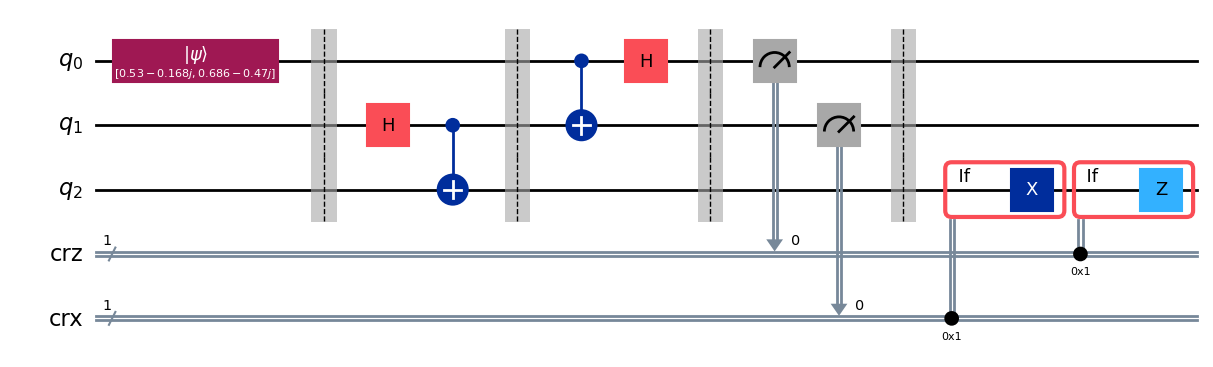

In [5]:
with teleportation_circuit.if_test((crx, 1)):
    teleportation_circuit.x(2)
with teleportation_circuit.if_test((crz, 1)):
    teleportation_circuit.z(2)

# Draw the circuit
teleportation_circuit.draw('mpl')

## Step 5: Verification and Analysis

We will now verify that the state has been successfully teleported to Bob's qubit ($q_2$). We will use the statevector simulator to check the final state of $q_2$.

Counts: {'1 1': 263, '0 1': 249, '1 0': 228, '0 0': 260}
Final System Statevector:


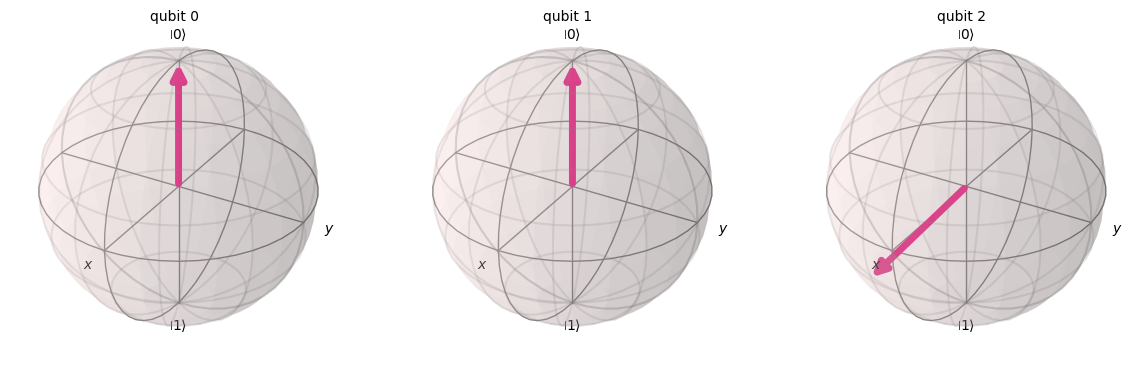

In [6]:
# Run the simulation
# Note: We need to use a simulator that supports conditional operations and statevector snapshots if we want to see the vector
# However, since we measured q0 and q1, the global state has collapsed.
# To verify, we can run the circuit and check the state of q2 for each shot, or use a specific technique.

# Let's use the Statevector object to simulate the evolution directly without explicit measurement for verification purposes first,
# OR we can just look at the final statevector of the system.

# Since we already added measurements, let's run it on the AerSimulator.
job = simulator.run(teleportation_circuit, shots=1000)
result = job.result()
counts = result.get_counts()
print("Counts:", counts)

# To rigorously prove the state is transferred, let's look at the statevector of q2.
# We can create a temporary circuit without measurements for statevector simulation, 
# BUT the protocol requires measurement. 
# Instead, we can use the 'save_statevector' instruction if supported, or simply observe that for any measurement outcome, q2 ends up in psi.

# Let's visualize the Bloch vector of q2. 
# Since q0 and q1 are measured, they will be |0> or |1>. q2 should be |psi>.

# We'll create a new circuit for statevector visualization that includes the logic but uses 'snapshot' or just runs on a statevector simulator.
# Actually, Qiskit's AerSimulator can return the final statevector even with intermediate measurements if we use save_statevector.

qc_verify = teleportation_circuit.copy()
qc_verify.save_statevector()
job_verify = simulator.run(qc_verify)
result_verify = job_verify.result()
final_state = result_verify.get_statevector()

print("Final System Statevector:")
# display(array_to_latex(final_state))

# The system state is a tensor product. We want to see the state of q2.
# Since q0 and q1 are measured and collapsed, we can trace them out or just look at the block sphere.
plot_bloch_multivector(final_state)

### Analysis of Results
In the Bloch sphere visualization above:
- **Qubit 0 (Alice)**: Is in state $|0\rangle$ (collapsed).
- **Qubit 1 (Alice)**: Is state $|0\rangle$ (collapsed).
- **Qubit 2 (Bob)**: Is in the state $|\psi\rangle$, matching the initial state we created.

This confirms that:
1. **Teleportation Successful**: Bob now has Alice's initial state.
2. **No Cloning**: Alice's original qubit $q_0$ no longer holds $|\psi\rangle$; it has collapsed to a basis state.

## Conclusion
We have successfully implemented and verified the quantum teleportation protocol. Alice's state was destroyed in the process of measuring her qubits, and the information was transferred to Bob's qubit using entanglement and classical communication, respecting the No-Cloning Theorem.